# <b>Twitter Text Mining</b>

## 1. Environment Setup

In [1]:
import tweepy
from tweepy import OAuthHandler
from nltk.corpus import stopwords
from PIL import Image
from wordcloud import WordCloud
import nltk
import pandas as pd
import numpy as np
#import re
import operator
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from operator import itemgetter

In [2]:
#nltk.download('stopwords')  # If stopwords has not been downloaded

## 2. Data Acquisition

In [3]:
#Set the hashtag to search
s="technology"

consumer_key = 'aTdTTqgBrfk5vfCqqItxGoByi'
consumer_secret = 'obHwzoYVGIOq7o3nD7r1ULouQZ27xgIlmzKSMEocx0UQ91m8iY'
access_token = '2943673172-brbBP1WgHciMM85Qq3cBCgJBaOEIdMSzxUfyKdQ'
access_token_secret = 'rMb4Lf0DWglxljacePbUUnbHrvp6kI4l4ZEV1qbob1r3b'
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

## 3. Data Preprocessing

In [4]:
n = 0
clean_words = []
lower_words = []
word_count = {}
word_count_n = {}

punctuations = '''!()-[]{};:"\,<>./?$%^&*_~@#'''
stop_words = set(stopwords.words('english'))
stop_words.add('rt')

## 4. Text Mining

In [5]:
for tweet in tweepy.Cursor(api.search, q=s, lang="en").items(500):
    n = n + 1
    # print(tweet.text)
    words = tweet.text.split()
    
    #Convert to lower letters
    for u in words:
        lower_words.append(u.lower())

    #Remove links and punctuations
    for w in lower_words:
        if w not in stop_words and w not in punctuations:
            if w[:4]=="http":
                continue
            nw = ""
            for c in w:
                if c not in punctuations:
                    nw = nw+c
            
            if len(nw)!=0:
                clean_words.append(nw)

    #Find frequency of all words
    for cw in clean_words:
        # print(cw)
        if cw not in word_count:
            word_count[cw] = 1
        else:
            word_count[cw] = word_count[cw] + 1
            
    #Use words that have atleast 50 occurences
    for cwt in word_count:
        if word_count[cwt] >= 50:
            word_count_n[cwt] = word_count[cwt]

## 5. Data visualization

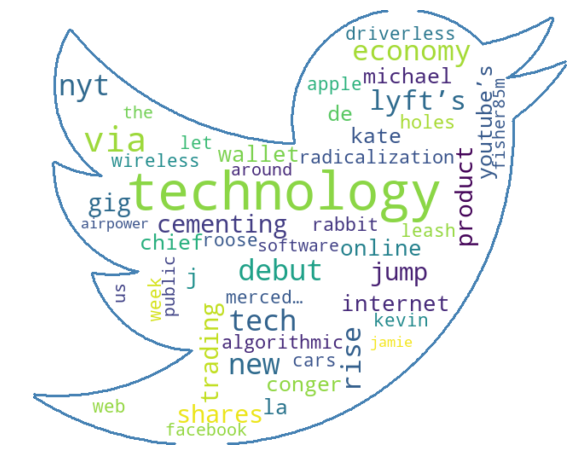

In [6]:
twitter_mask = np.array(Image.open("twitter_logo_black.png"))
wc = WordCloud(background_color="white", max_words=50, mask=twitter_mask,
                contour_width=3, contour_color='steelblue')
#wc = WordCloud(background_color="white", max_words=50,
#               stopwords=stopwords, contour_width=3, contour_color='steelblue')
wc.generate_from_frequencies(word_count_n)

# show
plt.figure(figsize=(10,8))
plt.axis("off")
#plt.savefig('twitter_word_cloud.png')
plt.imshow(wc, interpolation='bilinear')
plt.imsave('twitter_word_cloud.png', wc)

## 6. Clustering Analysis

In [7]:
# Load GloVe's embeddings
embeddings_index = {}
with open('/Users/George Thomas/Documents/Kevin_Python/Twitter_Clustering/glove.twitter.27B/glove.twitter.27B.200d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings:', len(embeddings_index))

Word embeddings: 1193514


In [8]:
# Create an 'average' embedding for each tweet

embedding_dim = 200 # Use 200 to match GloVe's embedding size

clean_tweets = list(word_count_n.keys())
embed_tweets = [] # Contains the 'average' embedding for each tweet
total_embeds = 0 
null_embeds = 0 

#np.seterr(divide='ignore', invalid='ignore')

for tweet in clean_tweets:
    avg_embed = np.zeros(embedding_dim) # Set default embedding for each tweet
    #avg_embed = np.seterr(divide='ignore', invalid='ignore')
    for word in tweet.split():
        total_embeds += 1
        embed = embeddings_index.get(word)
        if embed is not None:
            avg_embed += embed # Add embedding's values to vectors
        else:
            null_embeds += 1
    embed_tweets.append(avg_embed/len(tweet))

print("Total Number of Embeddings:", total_embeds)
print("Number of Null Embeddings:", null_embeds)
print("% of Embeddings that are Null: {}%".format(round(null_embeds/total_embeds,4)*100))

Total Number of Embeddings: 2577
Number of Null Embeddings: 737
% of Embeddings that are Null: 28.599999999999998%


In [9]:
# Reduce the dimensions of each tweet to 1
pca = PCA(n_components=1, random_state = 2)
pca_tweets = pca.fit_transform(embed_tweets)

In [10]:
# Order the tweets based on their PCA values, from low to high
# Similar tweets will be closer together
pca_tweets_list = [] # Contains the pca values
for tweet in pca_tweets:
    pca_tweets_list.append(tweet[0])

order = np.array(pca_tweets_list).argsort()
pca_labels = order.argsort()
pca_labels *= 2 # Multiple the labels by 2 so generated tweets can have odd values and 
                # Even values will represent tweets that were used for training

In [11]:
# Inspect pca_labels
pca_labels[:10]

array([ 242, 2954, 4272, 1740, 4670, 4438, 3220, 4622, 3512, 4052],
      dtype=int64)

In [12]:
# Group tweets by similarity
kmeans = KMeans(n_clusters=3, max_iter = 1000, n_init = 20, random_state=2).fit(pca_tweets)
labels = kmeans.labels_

In [13]:
# The number of tweets in each group.
pd.DataFrame(labels)[0].value_counts()

1    1766
2     724
0      87
Name: 0, dtype: int64

In [14]:
def top_n_words(group, n_words, group_no):
    '''Find the n most common words in each group'''
    vocab = {} # Create the vocabulary for each group
    for i in range(len(clean_tweets)):
        if labels[i] == group:
            for word in clean_tweets[i].split():
                if word not in vocab:
                    vocab[word] = 1
                else:
                    vocab[word] += 1
      
    # Sort the vocab from most to least common words
    sorted_vocab = sorted(vocab.items(), key=operator.itemgetter(1), reverse=True)
    top_n_words = {}
    for word, value in sorted_vocab:
        #top_n_words.append(word)
        top_n_words[word]=value
        
    wc = WordCloud(background_color="white", max_words=10,
                contour_width=3, contour_color='steelblue')
    #wc = WordCloud(background_color="white", max_words=50,
    #               stopwords=stopwords, contour_width=3, contour_color='steelblue')
    wc.generate_from_frequencies(top_n_words)

    # show
    plt.figure(figsize=(10,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    test='Group '+group_no
    plt.title(test)
    test=test+'.png'
    plt.savefig(test)
    #print(top_n_words.keys())

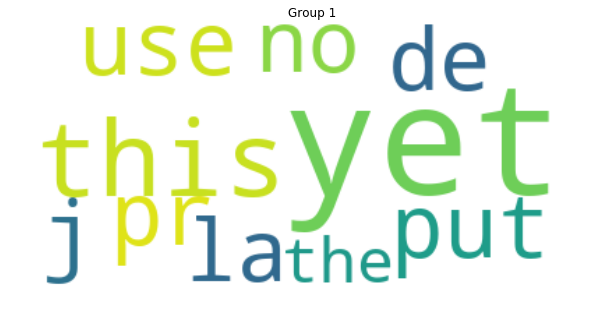

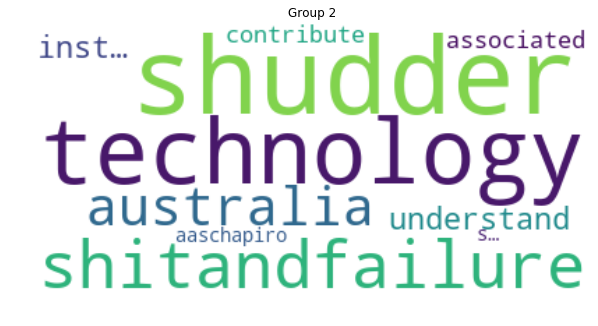

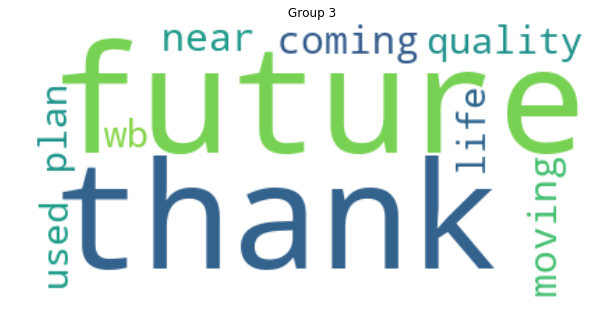

In [16]:
# The most common words in each group
groups = len(np.unique(labels))
for i in range(groups):
    #print("Group #",i+1)
    top_n_words(i, 3, str(i+1))

In [17]:
# The most common words for all of tweets
n_words = 100
sorted_vocab = sorted(word_count_n.items(), key=operator.itemgetter(1), reverse=True)
top_n_words = []
for word, value in sorted_vocab:
    if word not in stop_words:
        top_n_words.append(word)
    if len(top_n_words) == n_words:
        break
print("{} most popular tweeted words (not including stop words):".format(n_words))
print(top_n_words)

100 most popular tweeted words (not including stop words):
['technology', 'via', 'tech', 'debut', 'new', 'nyt', 'economy', 'lyft’s', 'rise', 'shares', 'gig', 'jump', 'trading', 'cementing', 'product', 'online', 'internet', 'wallet', 'kate', 'conger', 'michael', 'j', 'de', 'la', 'youtube’s', 'chief', 'radicalization', 'algorithmic', 'rabbit', 'holes', 'web', 'merced…', 'wireless', 'week', 'kevin', 'roose', 'apple', 'let', 'driverless', 'cars', 'leash', 'public', 'us', 'facebook', 'software', 'fisher85m', 'around', 'airpower', 'jamie', 'condliffe', 'platform', 'charging', 'people', 'gadgets', 'market', 'security', 'could', 'blog', 'advice', 'future', 't…', 'daily', 'two', '|', 'aerumofficial', 'aerum', 'incorporate', 'signkeys', 'secure', 'default', 'transactions', 'continuo…', 'years', 'times', 'digital', 'information', '2019', 'ipo', 'project', 'sleep', 'make', 'questions', 'mark', 'iot', 'social', 'last', 'news', 'rofl', 'even', 'though', 'lyft', 'york', 'blockchain', 'read', 'one', '

In [18]:
def print_tweet_group(group, n_tweets):
    '''Prints the first n_tweets in a group'''
    count = 1
    for i in range(len(clean_tweets)):
        if labels[i] == group:
            print("#{}: {}".format(count, clean_tweets[i]))
            count += 1
            if count == n_tweets+1:
                break

In [19]:
# Print the first few top tweets in each group
n_tweets = 3
for i in range(groups):
    print("Group #",i+1)
    print_tweet_group(i,n_tweets)
    print()

Group # 1
#1: yet
#2: this
#3: put

Group # 2
#1: shudder
#2: technology
#3: shitandfailure

Group # 3
#1: future
#2: thank
#3: coming



In [20]:
# Visualize the tweets with TSNE
model = TSNE(n_components=2, random_state=2)
TSNE_tweets = model.fit_transform(embed_tweets)

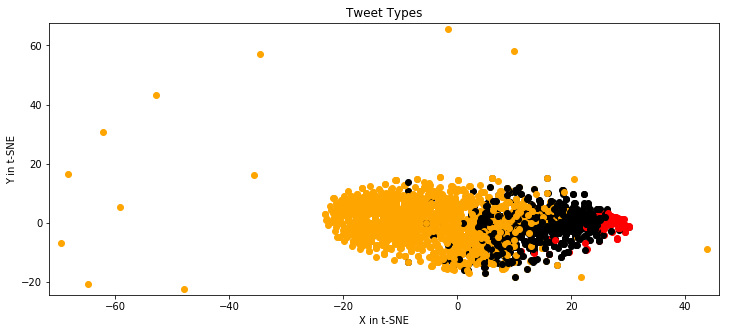

In [21]:
# Build a scatter plot to visualize the tweets.
#color_map = {0:'red', 1:'orange', 2:'black', 3:'blue', 4:'yellow'}
color_map = {0:'red', 1:'orange', 2:'black'}
plt.figure(figsize=(12,5))

for i in range(len(TSNE_tweets)):
    plt.scatter(x = TSNE_tweets[i][0], 
                y = TSNE_tweets[i][1],
                c = color_map[labels[i]])
plt.xlabel('X in t-SNE')
plt.ylabel('Y in t-SNE')
plt.title('Tweet Types')

offset = 2
x_min = min(TSNE_tweets, key=itemgetter(0))[0] - offset
x_max = max(TSNE_tweets, key=itemgetter(0))[0] + offset
y_min = min(TSNE_tweets, key=itemgetter(1))[1] - offset
y_max = max(TSNE_tweets, key=itemgetter(1))[1] + offset

axes = plt.gca()
axes.set_xlim([x_min,x_max])
axes.set_ylim([y_min,y_max])
plt.savefig('TSNE.png')

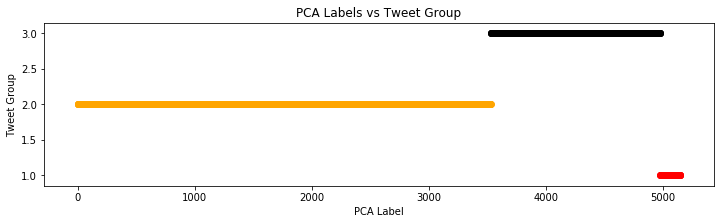

In [22]:
# Create a scatterplot to visualize the tweet groups by the PCA labels
plt.figure(figsize=(12,3))
for i in range(len(TSNE_tweets)):
    plt.scatter(x = pca_labels[i], 
                y = labels[i]+1,
                c = color_map[labels[i]])
    
plt.xlabel('PCA Label')
plt.ylabel('Tweet Group')
plt.title('PCA Labels vs Tweet Group')
    
plt.savefig('PCA.png')